# import libraries

In [ ]:
from glob import glob
import cv2
from matplotlib import pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split

from keras.applications import VGG16, ResNet50, MobileNet, MobileNetV2, InceptionV3, Xception, DenseNet169
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing import image
from keras.layers import Dense, Flatten
from tensorflow.keras.models import Model, Sequential
from keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from keras.optimizers import SGD
from xgboost import XGBClassifier

from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, confusion_matrix, f1_score, precision_score, recall_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Get Dataset

download

In [ ]:
! wget https://github.com/muhammedtalo/COVID-19/archive/refs/heads/master.zip

--2021-05-11 19:09:31--  https://github.com/muhammedtalo/COVID-19/archive/refs/heads/master.zip
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/muhammedtalo/COVID-19/zip/refs/heads/master [following]
--2021-05-11 19:09:31--  https://codeload.github.com/muhammedtalo/COVID-19/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 140.82.112.10
Connecting to codeload.github.com (codeload.github.com)|140.82.112.10|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘master.zip’

master.zip              [ <=>                ] 400.67M  29.7MB/s    in 14s     

2021-05-11 19:09:45 (29.0 MB/s) - ‘master.zip’ saved [420131804]



extract files

In [ ]:
! unzip -q master.zip -d /content

# Load Data

load images directory

In [ ]:
images_path = {}
images_path["Covid"] = glob("/content/COVID-19-master/X-Ray Image DataSet/Covid-19/*.png")
images_path["Covid"] += glob("/content/COVID-19-master/X-Ray Image DataSet/Covid-19/*.jpeg")
images_path["Covid"] += glob("/content/COVID-19-master/X-Ray Image DataSet/Covid-19/*.jpg")

images_path["NoFindings"] = glob("/content/COVID-19-master/X-Ray Image DataSet/No_findings/*.png")
images_path["NoFindings"] += glob("/content/COVID-19-master/X-Ray Image DataSet/No_findings/*.jpeg")
images_path["NoFindings"] += glob("/content/COVID-19-master/X-Ray Image DataSet/No_findings/*.jpg")

images_path["Pneumonia"] = glob("/content/COVID-19-master/X-Ray Image DataSet/Pneumonia/*.png")
images_path["Pneumonia"] += glob("/content/COVID-19-master/X-Ray Image DataSet/Pneumonia/*.jpeg")
images_path["Pneumonia"] += glob("/content/COVID-19-master/X-Ray Image DataSet/Pneumonia/*.jpg")

print(images_path["Covid"])
print(images_path["NoFindings"])
print(images_path["Pneumonia"])

images_class = {
    "Covid": 0,
    "Pneumonia": 1,
    "NoFindings": 2
}

['/content/COVID-19-master/X-Ray Image DataSet/Covid-19/ciaa199.pdf-001-b.png', '/content/COVID-19-master/X-Ray Image DataSet/Covid-19/ciaa199.pdf-001-a.png', '/content/COVID-19-master/X-Ray Image DataSet/Covid-19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-003-fig4a.png', '/content/COVID-19-master/X-Ray Image DataSet/Covid-19/23E99E2E-447C-46E5-8EB2-D35D12473C39.png', '/content/COVID-19-master/X-Ray Image DataSet/Covid-19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-001-fig2b.png', '/content/COVID-19-master/X-Ray Image DataSet/Covid-19/1-s2.0-S1684118220300682-main.pdf-003-b1.png', '/content/COVID-19-master/X-Ray Image DataSet/Covid-19/covid-19-pneumonia-14-PA.png', '/content/COVID-19-master/X-Ray Image DataSet/Covid-19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-002-fig3b.png', '/content/COVID-19-master/X-Ray Image DataSet/Covid-19/41591_2020_819_Fig1_HTML.webp-day5.png', '/content/COVID-19-master/X-Ray Image DataSet/Covid-19/1.CXRCTThoraximagesofCOVID-19fromSingapore.pdf-003

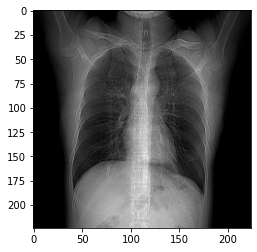

In [ ]:
X = []
Y = []

for label in images_path:
    for image_path in images_path[label]:
        image = cv2.imread(image_path)
        image = cv2.resize(image,(224, 224))
        X.append(image)
        Y.append(images_class[label])

plt.imshow(X[0])
plt.show()

In [ ]:
print(np.array(X).shape)
print(np.array(Y).shape)
print(Y[0])

(1125, 224, 224, 3)
(1125,)
0


# Build model

build model and get features

In [ ]:
x = np.array(X)
y = np.array(Y)


# initial pre trained model
pre_trained_models = {}
pre_trained_models["DenseNet169"] = DenseNet169(include_top=False, input_shape=(224, 224, 3), pooling="avg")


51879936/51877672 [==============================] - 0s 0us/step


In [ ]:
print(np.array(x).shape)

(1125, 224, 224, 3)


# Split train and test data 

slpit and make flatten features

In [ ]:
X_train, X_test, Y_train, Y_test = train_test_split(x, y, test_size=0.2)


X_train = pre_trained_models["DenseNet169"].predict(X_train)
X_test = pre_trained_models["DenseNet169"].predict(X_test)

flatten_feature_train = []
for item in X_train:
    flatten_feature_train.append(item.flatten())

flatten_feature_train = np.array(flatten_feature_train)

flatten_feature_test = []
for item in X_test:
    flatten_feature_test.append(item.flatten())

flatten_feature_test = np.array(flatten_feature_test)

# Classification

initial XGBoost classifier

In [50]:
# Y_pred = {}
result = {}

XGB_Classifier = XGBClassifier(learning_rate=0.26, n_estimators=100)
print(f"features shape : ", flatten_feature_train.shape)


features shape :  (900, 1664)


fit XGBoost classifier

In [51]:
XGB_Classifier.fit(flatten_feature_train, Y_train)

Y_pred = XGB_Classifier.predict(flatten_feature_test)

print result

In [52]:
result["Accuracy score"] = accuracy_score(Y_test, Y_pred)
result["confusion matrix"] = confusion_matrix(Y_test, Y_pred)
result["f1 score"] = f1_score(Y_test, Y_pred, average="macro")
result["precision score"] = precision_score(Y_test, Y_pred, average="macro")
result["Sensitivity"] = result["confusion matrix"][0,0] / (result["confusion matrix"][0,0] + result["confusion matrix"][0,1])
result["Specifity"] = result["confusion matrix"][1,1] / (result["confusion matrix"][1,0] + result["confusion matrix"][1,1])

print(f"\n============")
print(f"\nAccuracy score : ", result["Accuracy score"])
print(f"\nconfusion matrix : \n", result["confusion matrix"])
print(f"\nf1 score : ", result["f1 score"])
print(f"\nprecision score : ", result["precision score"])
print(f"\nSpecifity : ", result["Specifity"])
print(f"\nSensitivity : ", result["Sensitivity"])



Accuracy score :  0.88

confusion matrix : 
 [[20  1  0]
 [ 1 95 18]
 [ 0  7 83]]

f1 score :  0.899022312297097

precision score :  0.8988310758953842

Specifity :  0.9895833333333334

Sensitivity :  0.9523809523809523
